<a href="https://colab.research.google.com/github/SourLemon23/covid19-diagnosis/blob/master/COVID_19_CT_Diagnosis_V9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
try:
    %tensorflow_version 2.x
except:
    pass

print('Using TensorFlow Version:', tf.__version__)

import tensorflow.keras.backend as K
from tensorflow import GradientTape

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
%load_ext tensorboard

import scipy
print('Using SciPy Version:', scipy.__version__) # Should be 1.1.0

import os
from pathlib import Path
from PIL import Image
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import datetime
import random

# EfficientNetB7
! pip install -U efficientnet
from efficientnet.tfkeras import EfficientNetB7, preprocess_input

Using TensorFlow Version: 2.4.0
Using SciPy Version: 1.4.1
     |████████████████████████████████| 51kB 8.7MB/s 


In [ ]:
# Check if the hardware accelerator is set to GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# Authorize access to mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initialize dataset directories (Google Drive)
training_dir   = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V8/Training'
validation_dir = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V8/Validation'
testing_dir    = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V8/Testing'

In [ ]:
# Saved weights
checkpoint_filepath = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_model.h5'

In [55]:
# Tensorboard logs
logs = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/logs'

In [ ]:
# Initialize constants
CLASSES = ['COVID-19 Positive', 'COVID-19 Negative']

# Need 3 grayscale channels to be compatible w/ imagenet weights (RGB)
CHANNELS = 3
COLOR_MODE = 'rgb'
# ---------------------------------------------------------
# Should be 224 x 224? Found online 256 x 256?
# ---------------------------------------------------------
IMG_WIDTH, IMG_HEIGHT = 224, 224
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)
DARK_IMG_PXL_THRESHOLD = 200
MIN_NUM_CONTOURS = 5
SLICE_RANGE = 0.1

# BATCH_SIZE = 50
BATCH_SIZE = 32
EPOCHS = 1

# METRICS = [BinaryAccuracy(name='binary_accuracy'),
#            Precision(name='precision'),
#            Recall(name='recall')]
METRICS = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall')]

COVID_THRESHOLD = 0.05
EQUIDDST_MEAS = 0.5
NORMAL_THRESHOLD = 0.95

PERCENTAGE_FACTOR = 100;

font_settings = {'family': 'DejaVu Sans',
                  'color' : 'red',
                  'weight': 'heavy',
                  'size'  :  11}

**Data Preprocessing**

In [ ]:
def load_data(dir):
    img_paths = []

    for root, dirs, files in os.walk(dir):
        for filename in files:
            abs_path = os.path.abspath(os.path.join(root, filename))
            img_paths.append(abs_path)

    return img_paths

In [ ]:
# Crop the image along the contours
def lungs_region_auto_crop(img_path=None, img_array=None, is_nii=False, plot=False):
    cropped_img = None

    if img_path is not None:
        img = cv2.imread(img_path)
        img2 = img.copy()
    else:
        img = img_array
        img2 = img_array.copy()

    if is_nii:
        # print('Max pixel value:', np.max(img2))
        if np.max(img2) > DARK_IMG_PXL_THRESHOLD:
            binary_img_pxl_threshold = 110
        else:
            return None

    grayscale_img = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    smoothed_img = cv2.GaussianBlur(grayscale_img, (5, 5), 0)

    if is_nii:
        # binary_img = cv2.adaptiveThreshold(smoothed_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 23, 3)
        binary_img = cv2.threshold(smoothed_img, binary_img_pxl_threshold, 255, cv2.THRESH_BINARY)[1]
    else:
        binary_img = cv2.threshold(smoothed_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    kernel = np.ones((8, 8), dtype=np.uint8)
    eroded_img = cv2.erode(binary_img, kernel, iterations=1)
    dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(dilated_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(contour) for contour in contours]

    # print('# Contours:', len(areas))
    if len(areas) > MIN_NUM_CONTOURS or is_nii == False:
        max_index = np.argmax(areas)
        contour = contours[max_index]
        cv2.drawContours(img2, contours, -1, (0, 255, 0), 3)

        x, y, w, h = cv2.boundingRect(contour)
        xmin = x
        xmax = x + w
        ymin = y
        ymax = y + h
        cv2.rectangle(img2, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        cropped_img = img[ymin:ymax, xmin:xmax]

        if plot:
            fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(24, 4), constrained_layout=True)
            
            for i, img_filter in enumerate(['Grayscale', 'Smoothed', 'Binary', 'Eroded', 'Dilated', 'Contoured', 'Cropped']):
                axs[i].set_title(img_filter)

            axs[0].imshow(grayscale_img)
            axs[1].imshow(smoothed_img)
            axs[2].imshow(binary_img)
            axs[3].imshow(eroded_img)
            axs[4].imshow(dilated_img)
            axs[5].imshow(img2)
            axs[6].imshow(cropped_img)

            plt.show()

    return cropped_img

In [ ]:
def process_png_data(file_paths, crop=False):
    processed_png_imgs = []

    for img_path in file_paths:
        if crop == True:
            cropped_img = lungs_region_auto_crop(img_path=img_path)
            processed_png_imgs.append(cropped_img)
        else:
            img = cv2.imread(img_path)
            processed_png_imgs.append(img)

    return processed_png_imgs

In [ ]:
def process_nii_data(file_paths, crop=False):
    processed_nii_imgs = []
    png_img_paths = []

    for img_path in file_paths:
        img = nib.load(img_path)
        img_array_3d = img.get_fdata()

        # Convert image data type from float64 to uint8
        img_array_3d = cv2.normalize(src=img_array_3d, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        img_array_3d = np.rot90(img_array_3d, 3)
        height, width, slices = img_array_3d.shape
        mid_slice = slices / 2

        lower_slice_bound = int(mid_slice - (SLICE_RANGE * slices))
        upper_slice_bound = int(mid_slice + (SLICE_RANGE * slices))

        for slice_num in range(lower_slice_bound, upper_slice_bound + 1):
            img_array = img_array_3d[:, :, slice_num]
            img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)

            if crop == True:
                cropped_img = lungs_region_auto_crop(img_array=img_array, is_nii=True)
                if cropped_img is not None:
                    processed_nii_imgs.append(cropped_img)
                    before, sep, after = img_path.partition('.')
                    png_img_paths.append(before + '_slice_' + str(slice_num) + sep + 'png')
            else:
                processed_nii_imgs.append(img_array)
                before, sep, after = img_path.partition('.')
                png_img_paths.append(before + '_slice_' + str(slice_num) + sep + 'png')
    
    return png_img_paths, processed_nii_imgs

In [ ]:
def get_processed_data(img_paths, is_nii=False):
    if is_nii:
        png_img_paths, processed_nii_imgs = process_nii_data(img_paths, crop=True)
        return png_img_paths, processed_nii_imgs

    else:
        processed_png_imgs = process_png_data(img_paths, crop=True)
        return img_paths, processed_png_imgs

In [ ]:
def write_imgs(img_paths, processed_imgs, new_dir):
    for i, img_path in enumerate(img_paths):
        # print('img_path:', img_path)
        path_after_dir = r'/'.join(Path(img_path).parts[7:])
        # print('path_after_dir:', path_after_dir)
        final_img_path = Path(os.path.join(new_dir, path_after_dir))
        # print('final_img_path:', final_img_path)
        final_img_dir = final_img_path.parent
        # print('final_img_dir:', final_img_dir)

        if os.path.isdir(str(final_img_dir)) == False:
            os.makedirs(final_img_dir)
            print('New directory made:', final_img_dir)
          
        cv2.imwrite(str(final_img_path), processed_imgs[i])

In [ ]:
# Plot a batch of images with their labels
def visualize_data(data_generator):
    batch = data_generator.next()
    image_batch = batch[0]
    batch_labels = batch[1]

    fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(24, 14), constrained_layout=True)
    batch_length = len(image_batch)

    for i, image in enumerate(image_batch):
        if int(batch_labels[i]) == 0:
            title = 'COVID-19'
            font_settings.update({'color': 'red'})
        elif int(batch_labels[i]) == 1:
            title = 'Normal'
            font_settings.update({'color': 'blue'})

        if i < (1 / 4) * batch_length:
            axs[0, i].imshow(image_batch[i])
            axs[0, i].set_title(title, fontdict=font_settings)
        elif i < (2 / 4) * batch_length:
            axs[1, i - 8].imshow(image_batch[i])
            axs[1, i - 8].set_title(title, fontdict=font_settings)
        elif i < (3 / 4) * batch_length:
            axs[2, i - 16].imshow(image_batch[i])
            axs[2, i - 16].set_title(title, fontdict=font_settings)
        else:
            axs[3, i - 24].imshow(image_batch[i])
            axs[3, i - 24].set_title(title, fontdict=font_settings)

    plt.show()

In [ ]:
# Augment data
training_data_gen = ImageDataGenerator(rescale=1./255,              # Simplify pixel values to be 0-1
                                       horizontal_flip=True,        # Randomly flip images horizontally
                                       vertical_flip=True,          # Randomly flip images vertically
                                       zoom_range=0.1,             # Randomly zoom
                                       shear_range=0.1,            # Shear angle in counter-clockwise direction
                                       rotation_range=15,           # Randomly rotate
                                       width_shift_range=0.1,      # Randomly shift the image left/right
                                       height_shift_range=0.1,     # Randomly shift the image up/down
                                       brightness_range=(0.3, 1.2)) # Randomly adjust the brightness

validation_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Split data
training_generator = training_data_gen.flow_from_directory(training_dir,
                                                           color_mode=COLOR_MODE,
                                                           target_size=TARGET_SIZE,
                                                           class_mode='binary',
                                                           batch_size=BATCH_SIZE,
                                                           shuffle=True)

validation_generator = validation_data_gen.flow_from_directory(validation_dir,
                                                               color_mode=COLOR_MODE,
                                                               target_size=TARGET_SIZE,
                                                               class_mode='binary',
                                                               batch_size=BATCH_SIZE,
                                                               shuffle=True)

# testing_generator = testing_data_gen.flow_from_directory(testing_dir,
#                                                          color_mode=COLOR_MODE,
#                                                          target_size=TARGET_SIZE,
#                                                          class_mode='binary',
#                                                          batch_size=BATCH_SIZE,
#                                                          shuffle=True)

Found 16009 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


Training Batch:


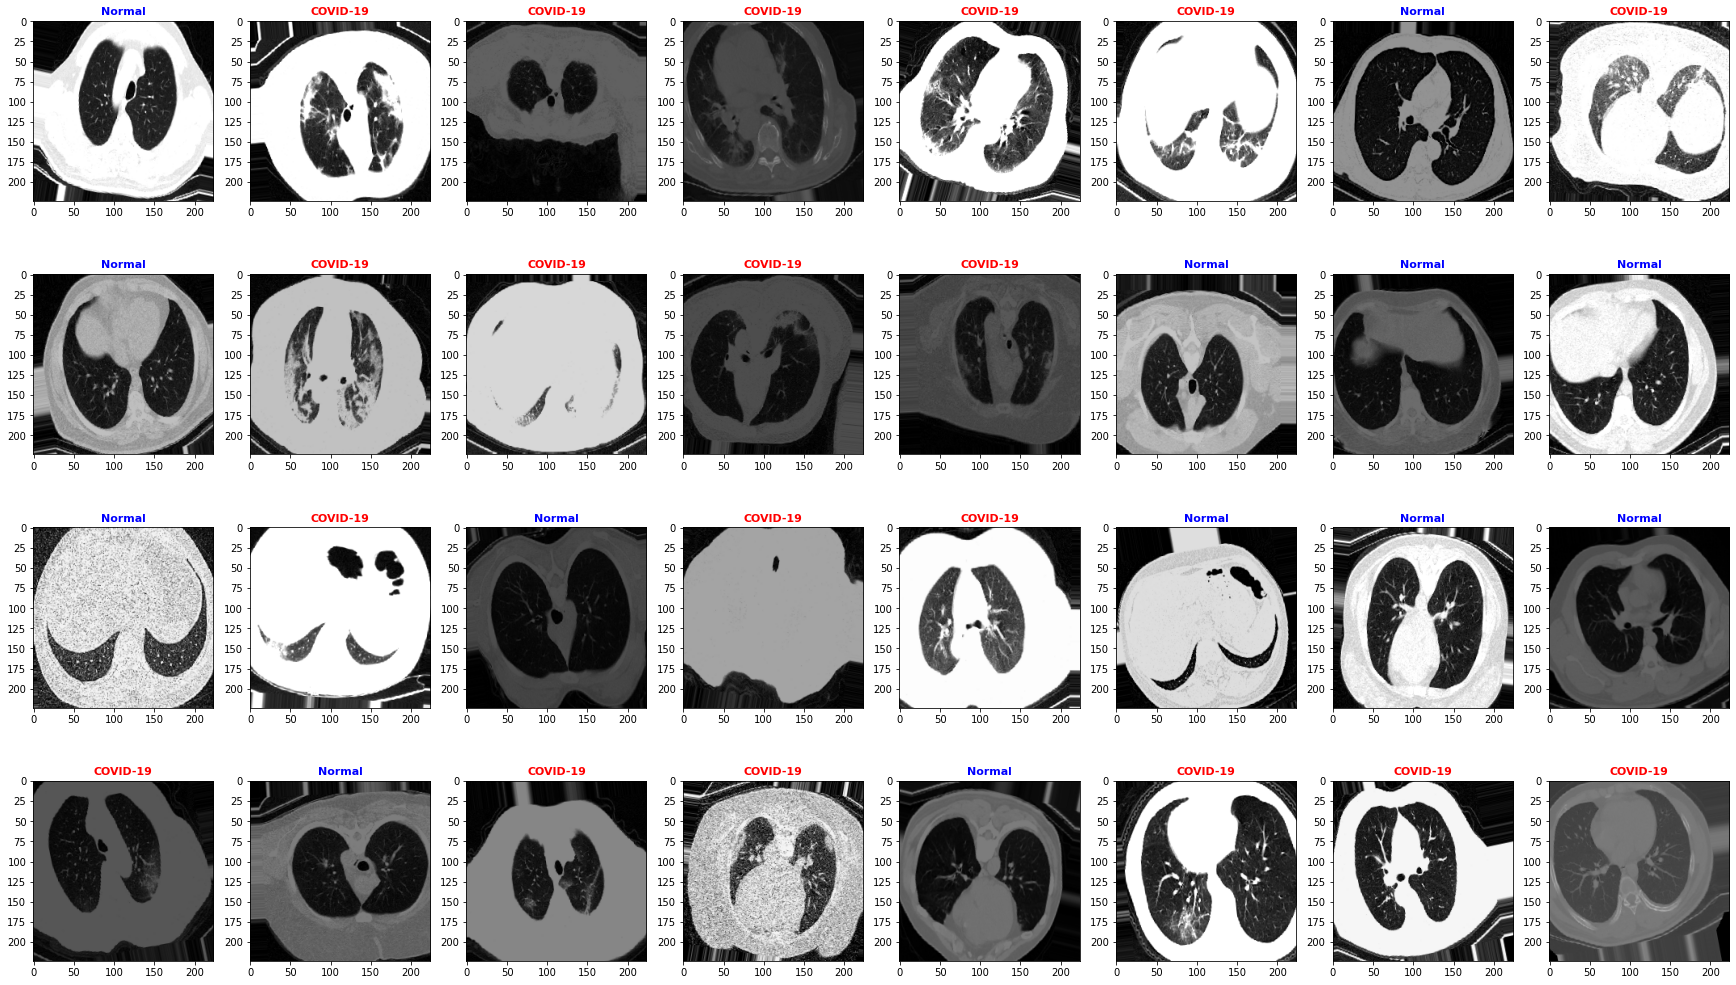


Validation Batch:


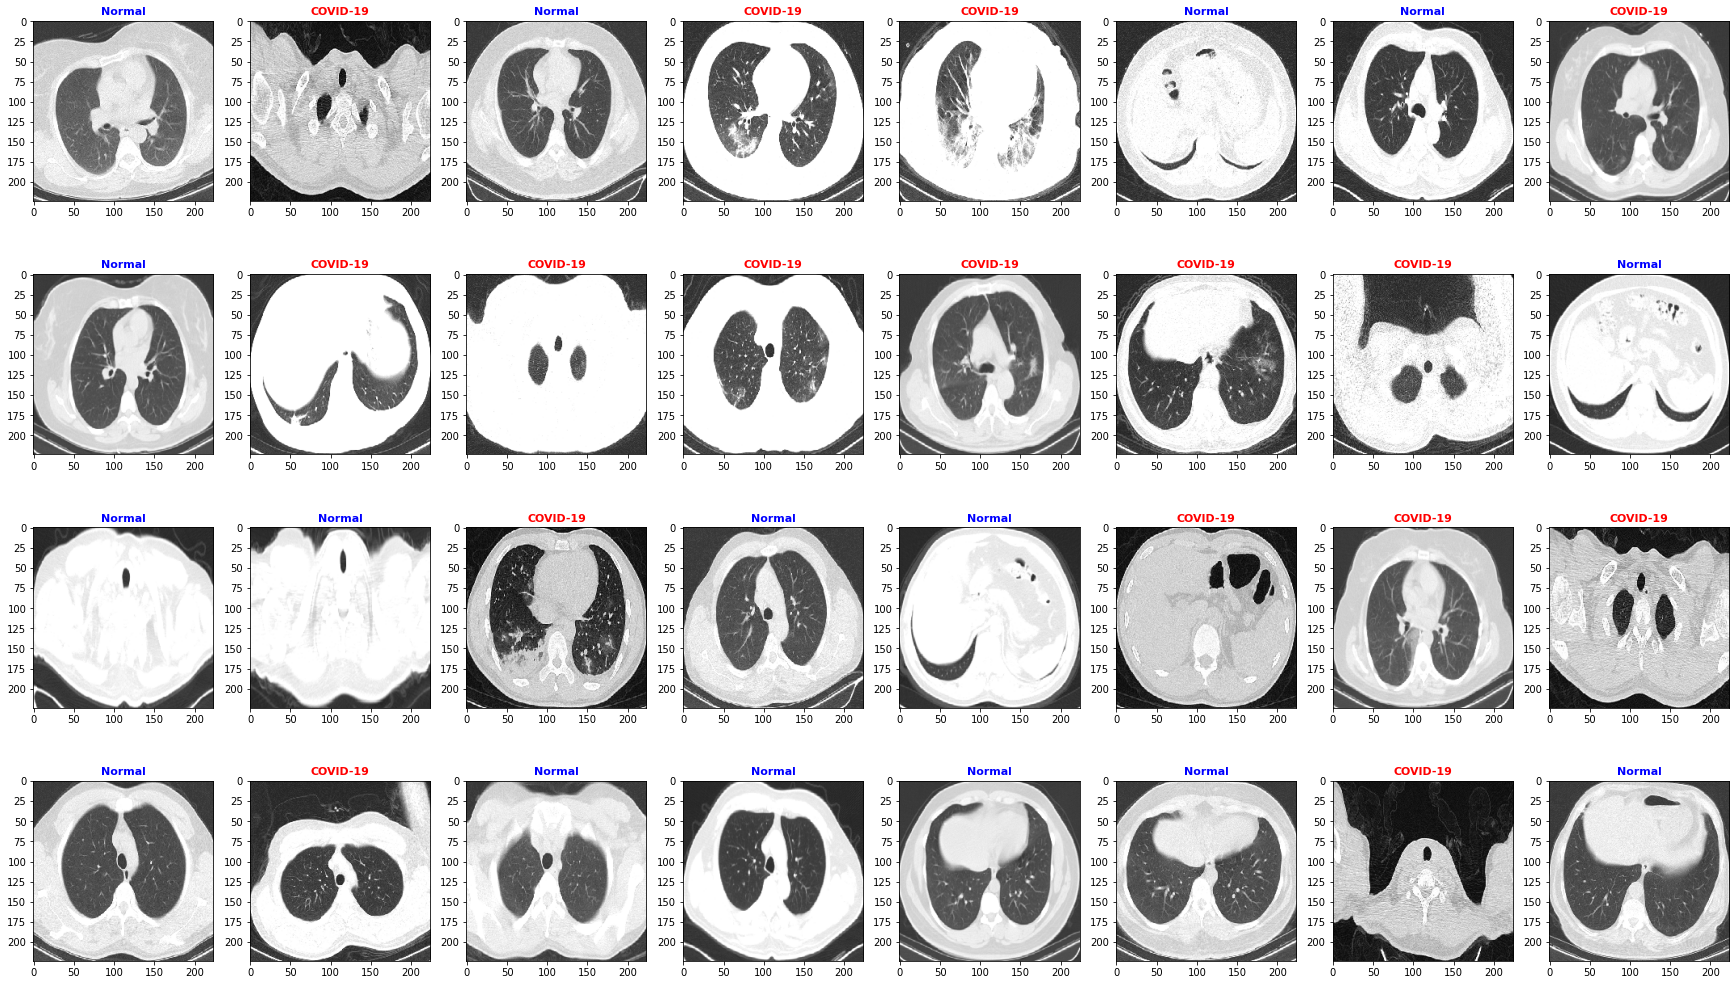

In [ ]:
print('Training Batch:')
visualize_data(training_generator)
print('\nValidation Batch:')
visualize_data(validation_generator)

**Building the Model**

In [ ]:
# Create a neural network
def create_model(print_summary=False):
    # Instantiate a base model with pre-trained weights
    base_model = EfficientNetB7(weights='imagenet',
                                include_top=False,
                                input_shape=INPUT_SHAPE)
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output

    # Add new classifier layers to the end of the base model
    # x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)

    # A final dense layer with a single neuron (binary classification)
    predictions = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.inputs, outputs=predictions)

    if print_summary:
        model.summary()

    return model

In [ ]:
# Configure model
def compile_model(model):
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(),
                  metrics=METRICS)

In [ ]:
# Train the model
def fit_model(model):
    checkpoint_cb = ModelCheckpoint(checkpoint_filepath,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

    early_stopping_cb = EarlyStopping(monitor='val_loss',
                                      min_delta=1e-3,
                                      patience=5,
                                      mode='min',
                                      restore_best_weights=True)
    
    log_dir = logs + r'/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_cb = TensorBoard(log_dir=log_dir,
                                 histogram_freq=1)
    
    callbacks = [checkpoint_cb, early_stopping_cb, tensorboard_cb]

    history = model.fit(training_generator,
                        epochs=EPOCHS,
                        steps_per_epoch=(training_generator.n/BATCH_SIZE),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/BATCH_SIZE),
                        callbacks=callbacks)
    
    # Update weights if they were further optimized during training
    model.load_weights(checkpoint_filepath)
    
    %tensorboard --logdir '$logs'
    
    return history

In [60]:
# %tensorboard --logdir '$logs'

In [106]:
# Visualize metrics with graphs
def evaluate_model(history):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 4), constrained_layout=True)

    for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
        if ('loss' in metric) is False:
            print('Best Training ' + metric.capitalize() + ':', str(history.history[metric][0] * 100)[:5] + '%')
            print('Best Validation ' + metric.capitalize() + ':', str(history.history['val_' + metric][0] * 100)[:5] + '%')
        else:
            print('Best Training ' + metric.capitalize() + ':', str(history.history[metric][0])[:5])
            print('Best Validation ' + metric.capitalize() + ':', str(history.history['val_' + metric][0])[:5])
        
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].set_title('Model {}'.format(metric.capitalize()))
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend(['Training', 'Validation'])

In [ ]:
# train_dir = r''
# val_dir = r''
# new_dir = r''

# train_img_paths = load_data(train_dir)
# val_img_paths = load_data(val_dir)
# print('Train length:', len(train_img_paths))
# print('Val length:', len(val_img_paths))

# new_train_img_paths, processed_train_imgs = get_processed_data(train_img_paths)
# print('New train length:', len(new_train_img_paths))
# print('# train imgs processed:', len(processed_train_imgs))
# new_val_img_paths, processed_val_imgs = get_processed_data(val_img_paths)
# print('New val length:', len(new_val_img_paths))
# print('# val imgs processed:', len(processed_val_imgs))

# write_imgs(new_train_img_paths, processed_train_imgs, new_dir)

In [ ]:
model = create_model(print_summary=False)
compile_model(model)

258441216/258434480 [==============================] - 3s 0us/step


In [ ]:
history = fit_model(model)

Best Training Accuracy: 74.26%
Best Validation Accuracy: 82.40%
Best Training Loss: 0.555
Best Validation Loss: 0.394
Best Training Precision: 72.87%
Best Validation Precision: 77.29%
Best Training Recall: 77.24%
Best Validation Recall: 91.75%


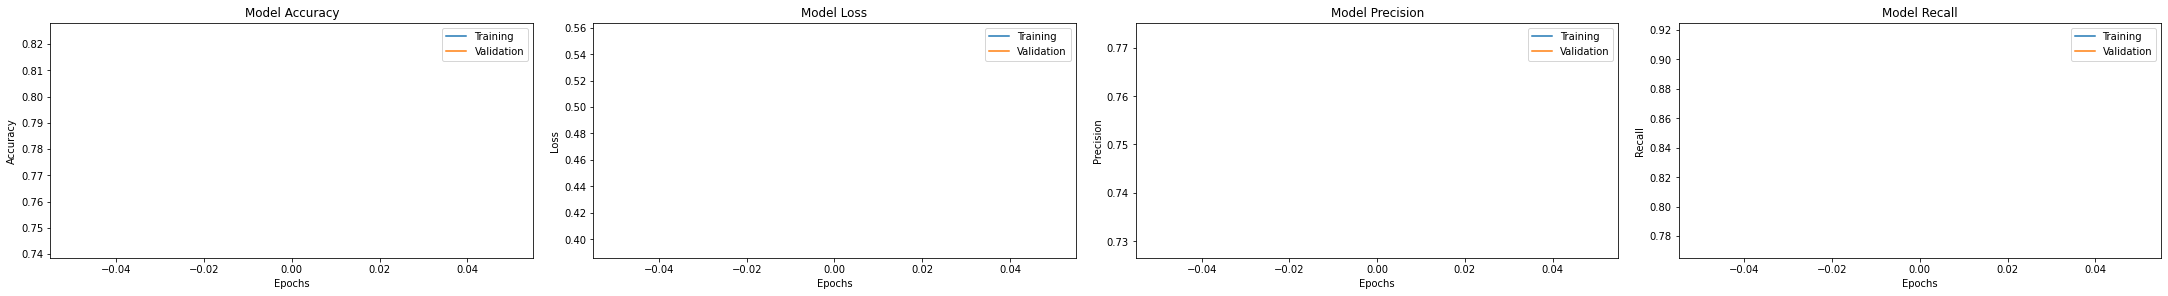

In [107]:
evaluate_model(history)

**Predicting Images**

In [171]:
def grad_CAM(model, orig_img, intensity_factor):
    with GradientTape() as tape:
        last_conv_layer = model.layers[-9] # top_conv (Conv2D)
        # print('last_conv_layer:', type(last_conv_layer))
        iterate = Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(orig_img.reshape(1, 224, 224, 3))
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape(7, 7)

    plt.matshow(heatmap)
    plt.show()

    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_HSV)
    # heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    dimmed_heatmap = heatmap * intensity_factor
    
    superimposed_img = ((dimmed_heatmap + orig_img) * 180).astype(np.uint8)
    # superimposed_img = dimmed_heatmap + orig_img

    plt.imshow(dimmed_heatmap)
    plt.show()
    plt.imshow(superimposed_img)
    plt.show()

In [175]:
# Predict a patient's CT scan
def run_diagnosis(model, img_path=None, img_array=None):
    disclaimer = '*** DISCLAIMER ***\n' \
             'Do not rely on this prediction for self-diagnosis. ' \
             'Please check with your local authority services for ' \
             'seeking medical assistance.'

    # a = plt.imread('https://lh3.googleusercontent.com/proxy/GoGROGCSVoylCPBvcWy2y8FtuT86Vzsg0cW7ZqW1EHUoKyyStH9dGdxSZV_ya41mbYGbfmm7PRt1QT-MOIe87tcp-m5glt7kteygIHpyz1VqUh2cCNK3AmMXN2S_dSScog3C3u4u6N1p2vieALS-4g')
    # plt.imshow(a)
    # plt.show()

    plt.text(2.5, 0.5,
            disclaimer,
            size=15,
            ha="center", va="center",
            bbox=dict(boxstyle="round",
                      ec=(1., 0., 0.),
                      fc=(1., 0.9, 0.9)))
    plt.axis('off')
    
    if img_path is not None:
        cropped_img = lungs_region_auto_crop(img_path=img_path, plot=True)
    else:
        cropped_img = lungs_region_auto_crop(img_array=img_array, plot=True)

    resized_img = np.asarray(tf.image.resize(cropped_img, TARGET_SIZE)).astype(np.uint8)
    resized_img = resized_img / 255

    testing_img = resized_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS)
    prediction = model.predict(testing_img)
    print('Prediction:', prediction)

    # Safe prediction for COVID-19 positive
    if prediction > 0 and prediction < COVID_THRESHOLD:
        class_index = 0
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str(((EQUIDDST_MEAS - prediction) / EQUIDDST_MEAS) * PERCENTAGE_FACTOR)[2:6]

        font_settings.update({'color': 'red'})
        plt.title(f'{network_prediction} ({network_percent_confidence} % match)', fontdict=font_settings)
        print()

    # Safe prediction for COVID-19 negative
    elif prediction < 1 and prediction > NORMAL_THRESHOLD:
        class_index = 1
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str(((prediction - EQUIDDST_MEAS) / EQUIDDST_MEAS) * PERCENTAGE_FACTOR)[2:6]
        
        font_settings.update({'color': 'blue'})
        plt.title(f'{network_prediction} ({network_percent_confidence} % match)', fontdict=font_settings)
        print()

    else:
        network_prediction = 'Uncertain'

        font_settings.update({'color': 'yellow'})
        plt.title(network_prediction, fontdict=font_settings)

    plt.imshow(cropped_img)
    plt.show()

    grad_CAM(model, resized_img, 0.0015)

True Label: COVID-19 Positive


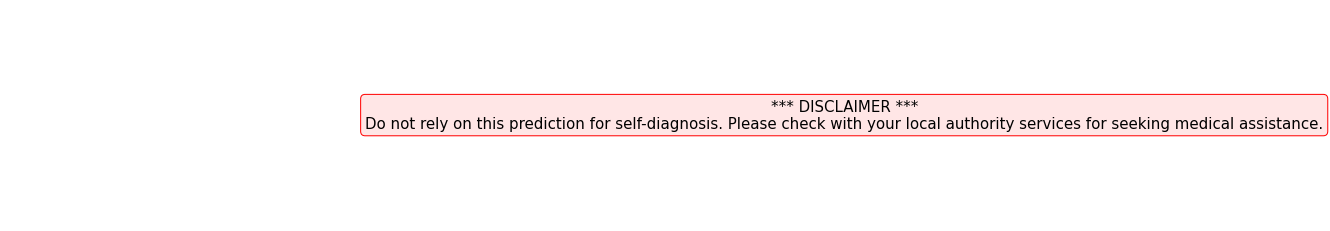

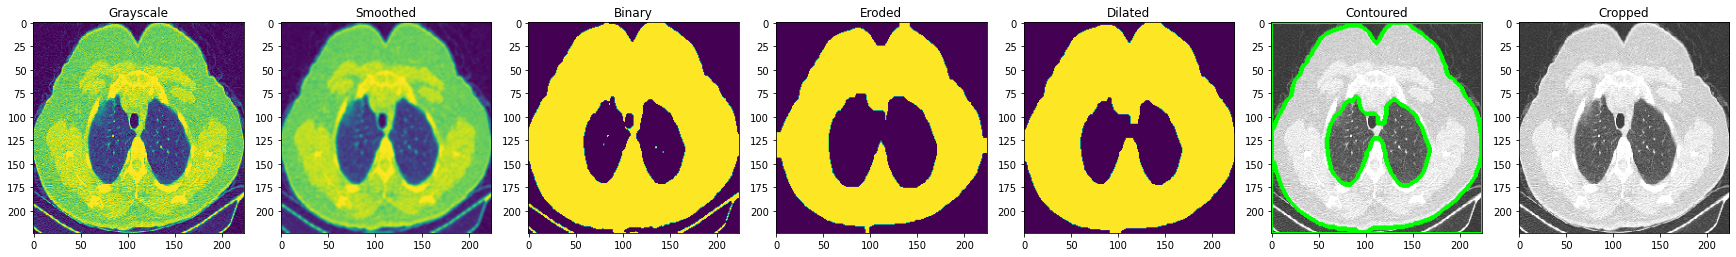

Prediction: [[0.81611735]]


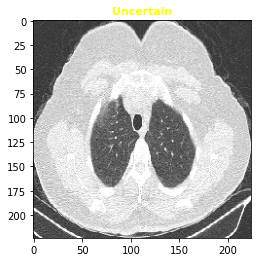

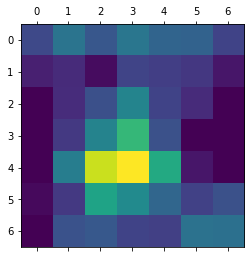

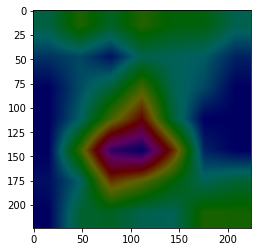

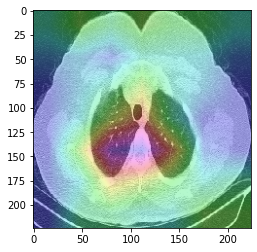

In [173]:
batch = validation_generator.next()
image_batch = batch[0]
batch_labels = batch[1]

testing_img_index = random.randint(0, len(image_batch) - 1)

orig_img = image_batch[testing_img_index]
true_label = CLASSES[int(batch_labels[testing_img_index])]

print('True Label:', true_label)

run_diagnosis(model, img_array=(orig_img * 255).astype(np.uint8))

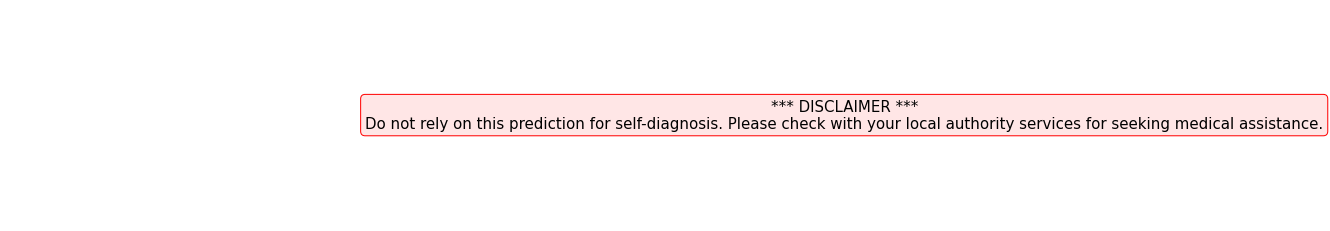

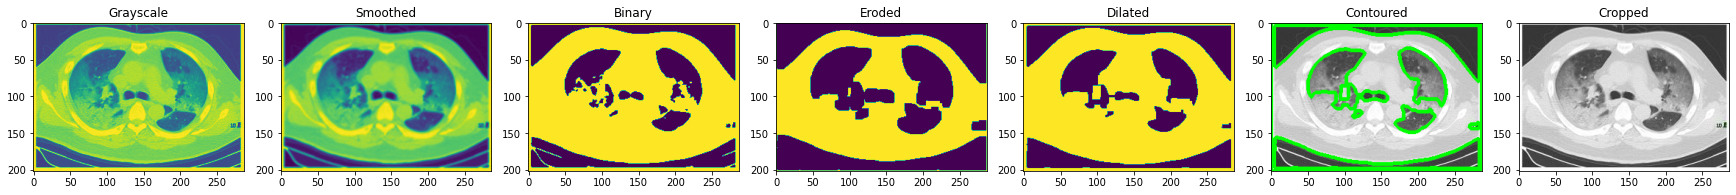

Prediction: [[0.04969132]]



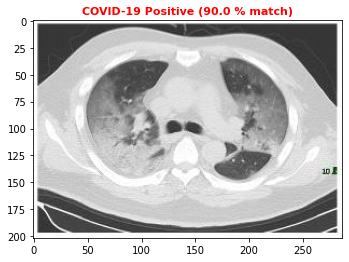

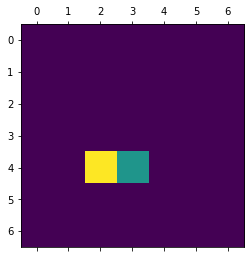

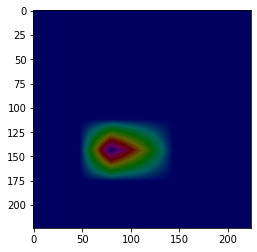

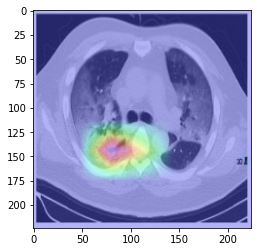

In [176]:
img_path = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/Testing/covid19/Kaggle COVID-19 Lung CT Scans/2020.02.10.20021584-p6-52%5.png'
run_diagnosis(model, img_path)

Test internet images (unreliable)

In [ ]:
# # Loop thorough all the image arrays stored in the DirectoryIterator
# for i in range(len(testing_generator[0][0])):
#     print(str(i + 1) + ": " + testing_generator.filepaths[i])

#     true_label_class_index = testing_generator.labels[i]
#     # true_label_class_index = testing_generator[0][1][i]
#     true_label = CLASSES[true_label_class_index]

#     # testing_image = cv2.normalize(src=testing_generator[0][0][i], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     testing_image = testing_generator[0][0][i]
    
#     print('True Label:', true_label)
#     print('Prediction:', prediction)

In [ ]:
# testing_dir = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/Testing'
# # testing_dir = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/Internet Images'

# # testing_data_gen = ImageDataGenerator(rescale=1./255)
# testing_data_gen = ImageDataGenerator()

# testing_generator = testing_data_gen.flow_from_directory(testing_dir,
#                                                          color_mode=COLOR_MODE,
#                                                          target_size=TARGET_SIZE,
#                                                          class_mode='binary',
#                                                          batch_size=BATCH_SIZE,
#                                                          shuffle=True)

Upload filepaths

In [ ]:
# Randomly pick and display an unseen image for the network to predict
def get_testing_image():
    # image_index = random.randint(0, len(testing_generator[0][0]))
    # testing_img = testing_generator[0][0][image_index]

    uploaded = files.upload()
   

    return testing_img_path

In [ ]:
# img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'
# plot_map(grad_top1)

# Upload files to test
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded.keys():
#     # print('User uploaded file "{name}" with length {length} bytes'.format(
#     #     name=filename, length=len(uploaded[filename])))

#     img_path = filename
#     img = load_img(img_path,
#                    color_mode=COLOR_MODE
#                    target_size=TARGET_SIZE)
#     img_array = img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     print(img_array)

In [ ]:
# #@title Enter Filepath Here:
# filename = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" #@param {type:"string"}

# img = image.load_img(filename,
#                      color_mode=COLOR_MODE
#                      target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# y = final_model.predict(x)

# predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
# actual="Normal" if "NORMAL" in filename else "Pneumonia" 

# img=mpimg.imread(filename)
# title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
# plt.title(title_text)
# imgplot=plt.imshow(img)

Confusion Matrix (from https://github.com/haydengunraj/COVIDNet-CT/blob/8599c2a87856326a18bbdf6ffa5987f9c1e64b4b/run_covidnet_ct.py#L213)

In [ ]:
# # Plot confusion matrix
#     fig, ax = plt.subplots()
#     disp = ConfusionMatrixDisplay(confusion_matrix=metrics['confusion matrix'],
#                                   display_labels=CLASS_NAMES)
#     disp.plot(include_values=True,
#               cmap='Blues', ax=ax,
#               xticks_rotation='horizontal',
#               values_format='.5g')
    
#     plt.show()

GRAD-Cam (https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759)

In [ ]:
# # Grad-CAM
# ! pip install keras==2.2.0
# ! pip install tensorflow==1.10.0
# ! pip install keras==2.2.2 # EfficientNet PyPi
# ! pip install tensorflow==1.12.0 # EfficientNet PyPi

# Versions that are compatible with vis
# ! pip install keras==2.2.4
# ! pip install tensorflow==1.14.0
# ! pip install keras_applications >= 1.0.7
# https://stackoverflow.com/questions/57773636/no-attribute-set-keras-submodules

# ! pip install vis
# ! pip install scipy==1.1.0

In [ ]:
# ! pip install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps
# import vis

# from vis.utils import utils
# from vis.visualization import visualize_cam

# --------------------------------------------
# FROM https://github.com/raghakot/keras-vis/blob/master/applications/self_driving/visualize_attention.ipynb
# --------------------------------------------
# for i, modifier in enumerate(modifiers):
#     heatmap = visualize_cam(model, layer_idx=-1, filter_indices=0, 
#                             seed_input=bgr_img, grad_modifier=modifier)
#     plt.figure()
#     plt.title(titles[i])
#     # Overlay is used to alpha blend heatmap onto img.
#     jet_heatmap = np.uint8(cm.jet(heatmap)[..., :3] * 255)
#     plt.imshow(overlay(img, jet_heatmap, alpha=0.7))

In [ ]:
# classifier_layer_names = ['top_conv', 'top_bn', 'top_activation', 'global_average_pooling2d_1', 'dropout_1', 'dense_3', 'dense_4', 'dense_5']
# last_conv_layer_name = 'block7d_add'

# img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'

# img = load_img(img_path,
#                color_mode=COLOR_MODE
#                target_size=TARGET_SIZE)

# img               = img_to_array(img)
# # img               = preprocess_input(img)
# y_pred            = model.predict(img[np.newaxis,...])
# class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
# # topNclass         = 5
# # for i, idx in enumerate(class_idxs_sorted[:topNclass]):
# #     print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
# #           i + 1,classlabel[idx],idx,y_pred[0,idx]))

# # Utility to search for layer index by name. 
# # ***********  Alternatively we can specify this as -1 since it corresponds to the last layer.  ***************
# layer_idx = utils.find_layer_idx(model, 'dense_8')
# # Swap softmax with linear
# model.layers[layer_idx].activation = tf.keras.activations.linear
# model = utils.apply_modifications(model)

# penultimate_layer_idx = utils.find_layer_idx(model, "top_conv") 
# class_idx  = class_idxs_sorted[0]
# seed_input = img
# grad_top1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
#                            penultimate_layer_idx = penultimate_layer_idx) # TRY TO LEAVE BLANK? -> OR AS 'none'?
#                           #  backprop_modifier     = None)
#                           #  grad_modifier         = None)

In [ ]:
# def plot_map(grads):
#     fig, axes = plt.subplots(1,2,figsize=(14,5))
#     axes[0].imshow(_img)
#     axes[1].imshow(_img)
#     i = axes[1].imshow(grads,cmap="jet", alpha=0.8)
#     fig.colorbar(i)
#     plt.suptitle("Pr(class={}) = {:5.2f}".format(
#                       classlabel[class_idx],
#                       y_pred[0,class_idx]))